In [22]:
import torch
import matplotlib.pyplot as plt
import torch
from torch.optim import LBFGS
import time
import numpy as np
import os
import torch.nn as nn
from torch.autograd import grad
import scipy.special  

device = torch.device('cpu')  # Usamos CPU para este ejemplo

In [23]:
# Definir la función legendre de forma vectorizada
def legendre(n, x, lb, ub):
    x = 2 * (x - lb) / (ub - lb) - 1    
    P0 = torch.ones_like(x)
    if n == 0:
        return P0
    P1 = x
    if n == 1:
        return P1
    for _ in range(2, n + 1):
        P0, P1 = P1, ((2 * _ - 1) * x * P1 - (_ - 1) * P0) / _
    return P1

 
 
#Evaluación de la serie de Legendre 2-D utilizando broadcasting
def evaluate_legendre_series(coefficients, leg_x, leg_y):
    n = int(torch.sqrt(torch.tensor(coefficients.numel()).float()))  # Convert to tensor before sqrt
    coefficients = coefficients.view(n, n)
    # Utilizando broadcasting para calcular la serie de Legendre
    result = torch.sum(coefficients[:, :, None, None] * leg_x[:, None, :, :] * leg_y[None, :, :, :], dim=(0, 1))
    return result.reshape(-1,1) 

# Function to compute derivatives
def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs = torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy

In [24]:
# Precomputar leg_x y leg_y una vez
start_precompute = time.time()

# Elige una suposición inicial para los coeficientes
N = 5  # Grado máximo de los polinomios de Legendre
initial_guess = torch.zeros(N*N, requires_grad=True, dtype=torch.float64, device=device)  # Suposición inicial para los coeficientes
lb, ub = 0, 1  # Límites de integración
# Datos de entrada para la función y los polinomios de Legendre
X1_grid, X2_grid = torch.meshgrid(torch.linspace(0, 1, 100, dtype=torch.float64, device=device), torch.linspace(0, 1, 100, dtype=torch.float64, device=device))
X1=X1_grid.reshape(-1,1)
X2=X2_grid.reshape(-1,1)
# Make X1 and X2 require gradients
X1.requires_grad_()
X2.requires_grad_()
n = int(torch.sqrt(torch.tensor(initial_guess.numel(), device=device)))
leg_x = torch.stack([legendre(i, X1, lb, ub).to(device).double() for i in range(n)], dim=0)
leg_y = torch.stack([legendre(j, X2, lb, ub).to(device).double() for j in range(n)], dim=0)

end_precompute = time.time()
time_precompute = end_precompute - start_precompute
print(f"Tiempo de precomputación de Legendre polynomials: {time_precompute:.4f} segundos")

Tiempo de precomputación de Legendre polynomials: 0.0012 segundos


In [25]:
# Define la función para la cual quieres calcular los coeficientes de la serie de Legendre
def f(x1, x2):
    return 16*(1 - x1) * x1 * (1 - x2) * x2
    #return x1*x2*(1-x1)*(1-x2)*torch.exp(x1-x2)

Loss: 123.32942209909866
Loss: 114.96142234776622
Loss: 39.09767753754741
Loss: 4.406285324572706
Loss: 0.1540827733765576
Loss: 0.10553553438815078
Loss: 0.07992719712470246
Loss: 0.038232914371187976
Loss: 0.00934790458657764
Loss: 0.005391582050721547
Loss: 0.0033570931535011816
Loss: 0.0024248557558927395
Loss: 0.0008233233518482856
Loss: 0.0001088945791844175
Loss: 5.693273753148228e-07
Loss: 7.718757856578466e-09
Loss: 4.548137217228538e-10
Loss: 1.6939027562339017e-10
Loss: 3.164437545440914e-13
Loss: 1.0915006376562456e-13
Loss: 9.636717249915427e-13
Loss: 8.644665887058492e-12
Loss: 7.754900272224745e-11
Loss: 6.527564555221352e-21
Tiempo de optimización: 0.5119 segundos
Tiempo de evaluación: 0.0000 segundos


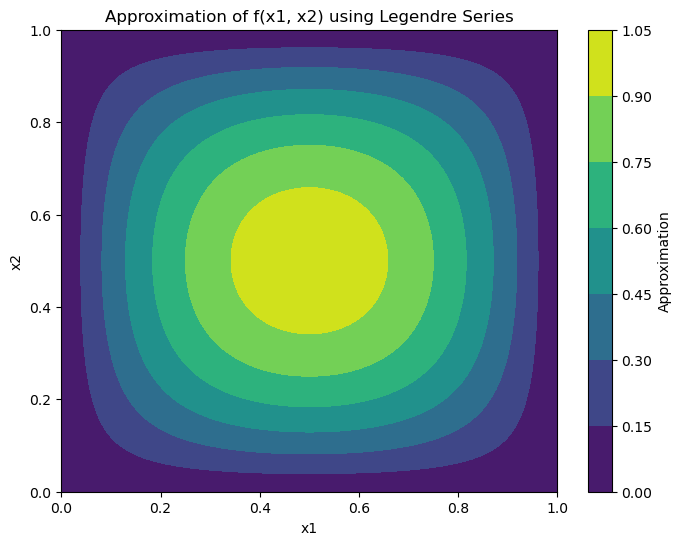

In [26]:
criterion = nn.MSELoss()
# Define la función de error
# Definir la función de error
def error_function(coefficients, leg_x, leg_y):
    N_xy_p = evaluate_legendre_series(coefficients, leg_x, leg_y)
    u_t = X1 * X2 * (X1 - 1) * (X2 - 1) * N_xy_p
    u_xx = derivative(u_t, X1, order=2) 
    u_yy = derivative(u_t, X2, order=2)
    residuo = u_xx + u_yy +  32 * ((1 - X2) * X2 + (1 - X1) * X1) 
    loss = torch.mean(residuo**2)
    return loss

# Usar una función de optimización para minimizar la función de error con respecto a los coeficientes
 
optimizer = torch.optim.LBFGS([initial_guess],
                                lr=1,
                                max_iter=50_000,
                                max_eval=50_000,
                                tolerance_grad=1e-10,
                                history_size=50,
                                tolerance_change=1.0 * np.finfo(float).eps,
                                line_search_fn=None)

def closure():
    optimizer.zero_grad()
    loss = error_function(initial_guess, leg_x, leg_y)
    print(f"Loss: {loss.item()}")
    loss.backward(retain_graph=True)
    return loss

# Realizar pasos de optimización
start_optimization = time.time()
optimizer.step(closure)
end_optimization = time.time()

# Coeficientes óptimos encontrados
optimal_coefficients = initial_guess.detach()

# Evaluar la aproximación de la serie de Legendre
start_evaluation = time.time()
approximation = evaluate_legendre_series(optimal_coefficients, leg_x, leg_y)
approximation = X1 * X2 * (X1 - 1) * (X2 - 1) * approximation
end_evaluation = time.time()

# Medir el tiempo de optimización y evaluación
time_optimization = end_optimization - start_optimization
time_evaluation = end_evaluation - start_evaluation

print(f"Tiempo de optimización: {time_optimization:.4f} segundos")
print(f"Tiempo de evaluación: {time_evaluation:.4f} segundos")

# Graficar el resultado usando contourf
plt.figure(figsize=(8, 6))
plt.contourf(X1.cpu().detach().numpy().reshape(X1_grid.shape), X2.cpu().detach().numpy().reshape(X1_grid.shape), approximation.cpu().detach().numpy().reshape(X1_grid.shape), cmap='viridis')
plt.colorbar(label='Approximation')
plt.title('Approximation of f(x1, x2) using Legendre Series')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [27]:
# Calcular el error en la predicción
prediction_error = error_function(optimal_coefficients, leg_x, leg_y)

print(f"Error en la predicción: {prediction_error.item()}")

Error en la predicción: 6.527564555221352e-21


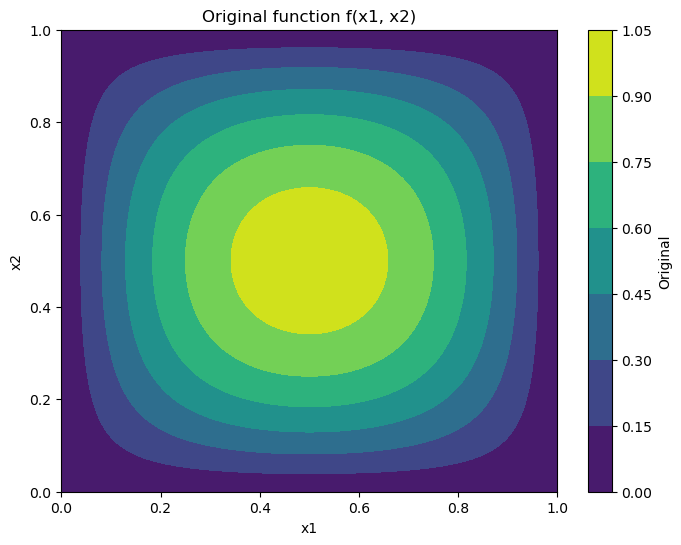

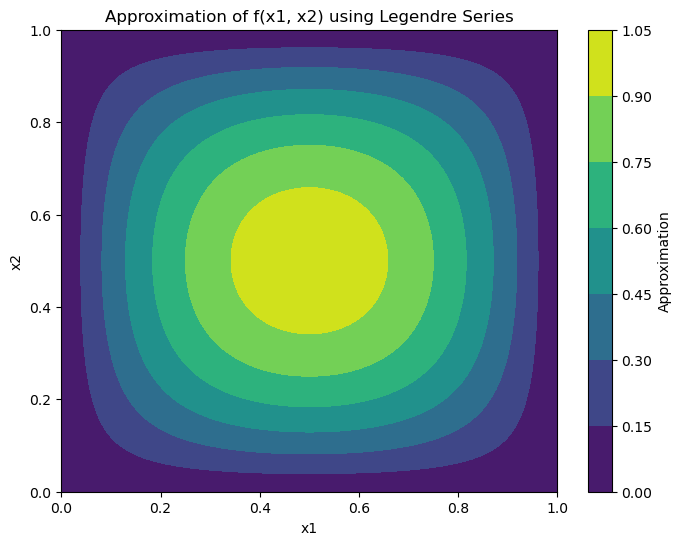

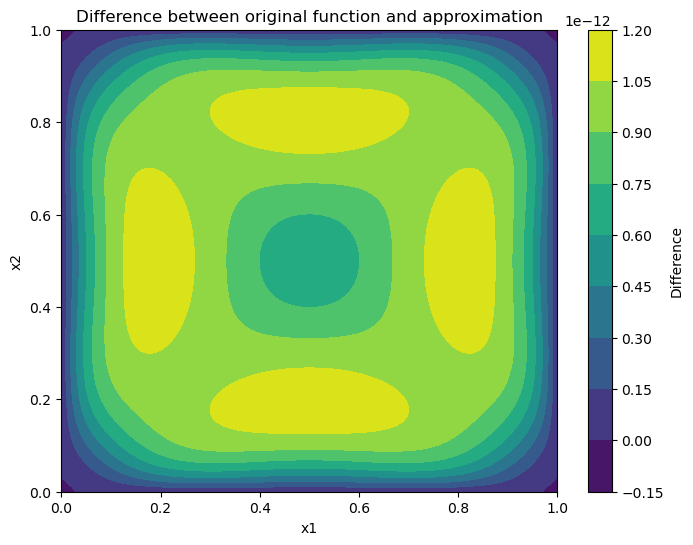

In [28]:
# Calcular la función original
original = f(X1, X2)

# Calcular la diferencia entre la función original y la aproximación
difference = original - approximation

# Graficar la función original
plt.figure(figsize=(8, 6))
plt.contourf(X1.cpu().detach().numpy().reshape(X1_grid.shape), X2.cpu().detach().numpy().reshape(X1_grid.shape), original.cpu().detach().numpy().reshape(X1_grid.shape), cmap='viridis')
plt.colorbar(label='Original')
plt.title('Original function f(x1, x2)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Graficar la aproximación
plt.figure(figsize=(8, 6))
plt.contourf(X1.cpu().detach().numpy().reshape(X1_grid.shape), X2.cpu().detach().numpy().reshape(X1_grid.shape), approximation.cpu().detach().numpy().reshape(X1_grid.shape), cmap='viridis')
plt.colorbar(label='Approximation')
plt.title('Approximation of f(x1, x2) using Legendre Series')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Graficar la diferencia
plt.figure(figsize=(8, 6))
plt.contourf(X1.cpu().detach().numpy().reshape(X1_grid.shape), X2.cpu().detach().numpy().reshape(X1_grid.shape), difference.cpu().detach().numpy().reshape(X1_grid.shape), cmap='viridis')
plt.colorbar(label='Difference')
plt.title('Difference between original function and approximation')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()